# Gráfico de una región

Ejemplo para el cálculo de la humedad relativa media en una región

In [2]:
import xarray as xr
import h5netcdf
import datetime
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import regionmask

Se define la fecha de inicialización del pronóstico.

In [3]:
año_fcst = 2022
mes_fcst = 3
dia_fcst = 21
hora_fcst = 0

Se define el período entre los que se va a promediar la humedad relativa

In [4]:
año_ini = 2022
mes_ini = 3
dia_ini = 21
hora_ini = 0

año_fin = 2022
mes_fin = 3
dia_fin = 21
hora_fin = 23

Se define la región a graficar

In [5]:
lat_min = -60
lat_max = -30
lon_min = -80
lon_max = -60

Lectura de los pronóstico

In [ ]:
FECHA_FCST = datetime.datetime(año_fcst, mes_fcst, dia_fcst, hora_fcst)

FECHA_INI = datetime.datetime(año_ini, mes_ini, dia_ini, hora_ini)
FECHA_FIN = datetime.datetime(año_fin, mes_fin, dia_fin, hora_fin)

#Plazo de pronóstico
plazo_ini = int((FECHA_INI - FECHA_FCST).total_seconds()/3600)
plazo_fin = int((FECHA_FIN - FECHA_FCST).total_seconds()/3600)

fs = s3fs.S3FileSystem(anon=True)

files = [f'smn-ar-wrf/DATA/WRF/DET/{FECHA_FCST:%Y/%m/%d/%H}/WRFDETAR_01H_{FECHA_FCST:%Y%m%d_%H}_{plazo:03d}.nc' for plazo in range(plazo_ini, plazo_fin)]

ds_list = []
for s3_file in files:
    print(s3_file)
    if fs.exists(s3_file):
        f = fs.open(s3_file)
        ds_tmp = xr.open_dataset(f, decode_coords = 'all', engine = 'h5netcdf')
        ds_list.append(ds_tmp)
    else:
        print('el archivo {} no existe'.format(s3_file))

ds = xr.combine_by_coords(ds_list, combine_attrs = 'drop_conflicts')

Se seleccionan los datos pertenecientes a la región y se calcula la temperatura mínima media diaria

In [8]:
esquinas = [[lon_min, lat_min], [lon_min, lat_max], [lon_max, lat_max], [lon_max, lat_min]]

#Armo la mascara de la región
region = regionmask.Regions([esquinas])
mascara = region.mask(ds['lon'], ds['lat'])

#selecciono la variable HR2 y calculo el valor medio diario
HR = ds[['HR2']]
HR_media = HR.mean(dim = 'time')

#Aplico la mascara eliminando los valores por fuera de esta
HR_region = HR_media.where(mascara == 0, drop = True)

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


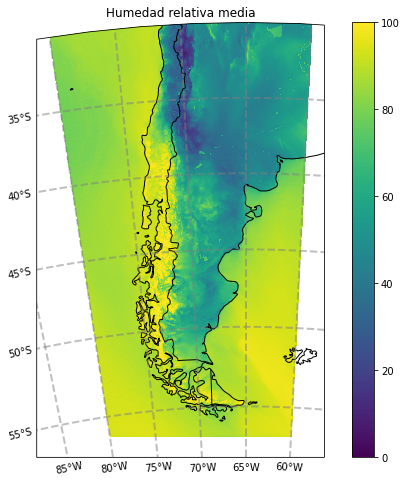

In [11]:
# Determino la proyeccion de los datos
proyeccion = ccrs.LambertConformal(central_longitude = ds.CEN_LON, 
                                   central_latitude = ds.CEN_LAT, 
                                   standard_parallels = (ds.TRUELAT1, 
                                                         ds.TRUELAT2))

fig = plt.figure(figsize = (10, 8)), 
ax = plt.axes(projection = proyeccion)
cbar = ax.pcolormesh(HR_region['lon'], HR_region['lat'], HR_region['HR2'], transform = ccrs.PlateCarree(), vmin = 0, vmax = 100)
ax.add_feature(cf.COASTLINE) #Agrega las costas
ax.add_feature(cf.BORDERS) #Agrega los limites de los paises
ax.set_title(f'Humedad relativa media')

gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, x_inline = False,
                  linewidth = 2, color = 'gray', alpha = 0.5, linestyle = '--')
gl.top_labels = False
gl.right_labels = False
plt.colorbar(cbar)